In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_types = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    #'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Breast_Mammary_Tissue',
    'Cells_EBV-transformed_lymphocytes',
    'Cells_Transformed_fibroblasts',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    #'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Liver',
    'Lung',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]


In [3]:
len(tissue_types)

44

In [4]:
#Load pre-processed dataframes

polyadb_df = pd.read_csv('../../aparent/data/native_data/polyadb/processed_data/polyadb_processed.csv', sep=',')
polyadb_df = polyadb_df.loc[~polyadb_df['gene'].isna()].reset_index(drop=True).copy()
polyadb_df = polyadb_df.loc[polyadb_df['gene'] != 'na'].reset_index(drop=True).copy()
polyadb_df = polyadb_df[['gene_id', 'site_type']]

#All aQTLs
qtl_df = pd.read_csv("../../aparent/misc/get_apaqtl_data/polyadb_median_all_SNPs.csv", sep='\t')

#Cis-acting aQTLs
cis_qtl_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_median_predictions_pred_df.csv", sep='\t')

cis_qtl_df['cut_to_snp'] = np.abs(cis_qtl_df['snp_pos'] - 100)
cis_qtl_df = cis_qtl_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

cis_qtl_df = cis_qtl_df.query("snp_pos > 20 and snp_pos < 126 and pas != -1")

#Lead Cis-acting aQTLs
lead_cis_qtl_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_median_lead_predictions_pred_df.csv", sep='\t')

lead_cis_qtl_df['cut_to_snp'] = np.abs(lead_cis_qtl_df['snp_pos'] - 100)
lead_cis_qtl_df = lead_cis_qtl_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

lead_cis_qtl_df = lead_cis_qtl_df.query("snp_pos > 20 and snp_pos < 126 and pas != -1")


Sizes = [553348, 2043, 366]


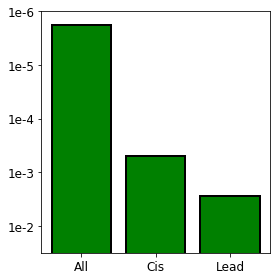

In [5]:

f = plt.figure(figsize=(4, 4))

print("Sizes = " + str([len(qtl_df), len(cis_qtl_df), len(lead_cis_qtl_df)]))

plt.bar(np.arange(3), np.log(np.array([len(qtl_df), len(cis_qtl_df), len(lead_cis_qtl_df)])) / np.log(10), edgecolor='black', linewidth=2, color='green')

plt.xticks(np.arange(3), ['All', 'Cis', "Lead"], fontsize=12)
plt.yticks([2, 3, 4, 5, 6], ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6'], fontsize=12)

plt.ylim(1.5, 6.)

plt.tight_layout()

plt.savefig("gtex_aqtl_aggregate_bars_lead_50bp.png", transparent=True, dpi=300)
plt.savefig("gtex_aqtl_aggregate_bars_lead_50bp.eps")

plt.show()


Total n = 3858
n (+) = 1907
n (-) = 1951
n (> 1.5-fold) = 111
n (> 2-fold) = 52
n (> 4-fold) = 22
n (> 8-fold) = 12
n (> 16-fold) = 7
n (> 32-fold) = 1
n (< 1.5-fold) = 101
n (< 2-fold) = 46
n (< 2-fold) = 46
n (< 4-fold) = 20
n (< 8-fold) = 9
n (< 16-fold) = 6
n (< 32-fold) = 1


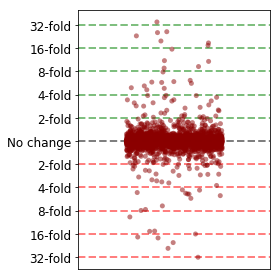

In [6]:

cis_qtl_df['delta_isoform_logodds_base2'] = cis_qtl_df['delta_isoform_logodds'] / np.log(2)

print("Total n = " + str(len(cis_qtl_df)))

print("n (+) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 >= 0."))))
print("n (-) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < 0."))))

print("n (> 1.5-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 0.585"))))
print("n (> 2-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 1."))))
print("n (> 4-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 2."))))
print("n (> 8-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 3."))))
print("n (> 16-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 4."))))
print("n (> 32-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 > 5."))))

print("n (< 1.5-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -0.585"))))
print("n (< 2-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -1."))))
print("n (< 2-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -1."))))
print("n (< 4-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -2."))))
print("n (< 8-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -3."))))
print("n (< 16-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -4."))))
print("n (< 32-fold) = " + str(len(cis_qtl_df.query("delta_isoform_logodds_base2 < -5."))))

f = plt.figure(figsize=(4, 4))

sns.stripplot(data=[cis_qtl_df['delta_isoform_logodds_base2']], alpha=0.5, color='darkred', s=5, jitter=0.25)

plt.axhline(y=-5, linewidth=2, linestyle='--', alpha=0.5, color='red')
plt.axhline(y=-4, linewidth=2, linestyle='--', alpha=0.5, color='red')
plt.axhline(y=-3, linewidth=2, linestyle='--', alpha=0.5, color='red')
plt.axhline(y=-2, linewidth=2, linestyle='--', alpha=0.5, color='red')
plt.axhline(y=-1, linewidth=2, linestyle='--', alpha=0.5, color='red')
#plt.axhline(y=-0.585, linewidth=2, linestyle='--', alpha=0.5, color='lightcoral')

plt.axhline(y=0, linewidth=2, linestyle='--', alpha=0.5, color='black')

#plt.axhline(y=0.585, linewidth=2, linestyle='--', alpha=0.5, color='lightgreen')
plt.axhline(y=1, linewidth=2, linestyle='--', alpha=0.5, color='green')
plt.axhline(y=2, linewidth=2, linestyle='--', alpha=0.5, color='green')
plt.axhline(y=3, linewidth=2, linestyle='--', alpha=0.5, color='green')
plt.axhline(y=4, linewidth=2, linestyle='--', alpha=0.5, color='green')
plt.axhline(y=5, linewidth=2, linestyle='--', alpha=0.5, color='green')

plt.xticks([], [])
plt.yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], ['32-fold', '16-fold', '8-fold', '4-fold', '2-fold', 'No change', '2-fold', '4-fold', '8-fold', '16-fold', '32-fold'], fontsize=12)

plt.tight_layout()

plt.savefig("gtex_aqtl_delta_logodds_pred_swarm.png", transparent=True, dpi=300)
plt.savefig("gtex_aqtl_delta_logodds_pred_swarm.eps")

plt.show()


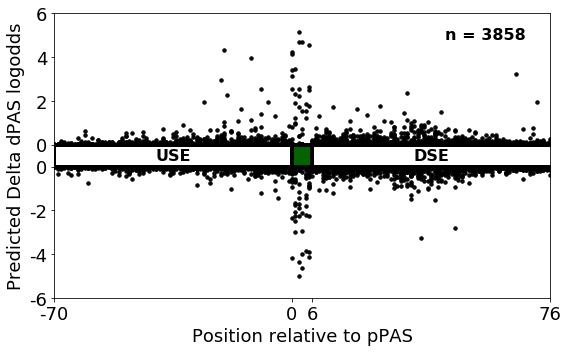

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

df = cis_qtl_df

fig_name = 'gtex_aqtl_delta_pos_scatter'

snv_pos_column = 'snp_pos'
pred_column = 'delta_isoform_logodds_base2'
p_val_column = 'p_val'

sort_pred = True
show_stats = True
color_by_p_val = False

fig = plt.figure(figsize=(8, 5))

annotation_height = 1.0

border_eta = 0.00

dot_size=12
dot_alpha=0.95

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = -1. * (np.log(np.ravel(df[p_val_column].values)) / np.log(10.))
delta_logodds_pred = np.ravel(df[pred_column].values)

vmin = np.quantile(p_val_true, q=0.05)
vmax = np.quantile(p_val_true, q=0.95)

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="bwr", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-7, -5, -3, -1, 0, 2, 4, 6], [-6, -4, -2, 0, 0, 2, 4, 6], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('Predicted Delta dPAS logodds', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-7, 6)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=300, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()


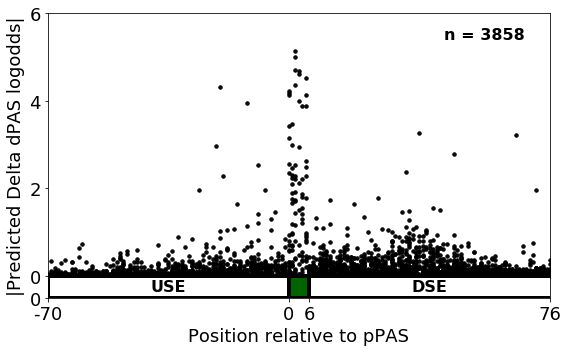

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

df = cis_qtl_df

fig_name = 'gtex_aqtl_delta_pos_scatter_abs'

snv_pos_column = 'snp_pos'
pred_column = 'delta_isoform_logodds_base2'
p_val_column = 'p_val'

sort_pred = True
show_stats = True
color_by_p_val = False

fig = plt.figure(figsize=(8, 5))

annotation_height = 0.5

border_eta = 0.00

dot_size=12
dot_alpha=0.95

snv_pos = np.ravel(df[snv_pos_column].values) - 70
p_val_true = -1. * (np.log(np.ravel(df[p_val_column].values)) / np.log(10.))
delta_logodds_pred = np.abs(np.ravel(df[pred_column].values))

vmin = np.quantile(p_val_true, q=0.05)
vmax = np.quantile(p_val_true, q=0.95)

n_points = len(df)

if sort_pred :
    sort_index = np.argsort(np.abs(p_val_true))
    snv_pos = snv_pos[sort_index]
    p_val_true = p_val_true[sort_index]
    delta_logodds_pred = delta_logodds_pred[sort_index]

delta_logodds_pred[delta_logodds_pred < 0.0] -= annotation_height
ax = plt.gca()
ax.add_patch(Rectangle((-70 + border_eta, -annotation_height + border_eta), 70 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))
ax.add_patch(Rectangle((0 + border_eta, -annotation_height + border_eta), 6 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='darkgreen', edgecolor='black', lw=4))
ax.add_patch(Rectangle((6 + border_eta, -annotation_height + border_eta), 76 - 2.*border_eta, annotation_height - 2.*border_eta, fill=True, facecolor='white', edgecolor='black', lw=4))

use_start = -70
use_end = 0
if use_end - use_start > 10 :
    ax.text(use_start + (use_end - use_start) / 2., -annotation_height/2., 'USE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

dse_start = 6
dse_end = 76
if dse_end - dse_start > 10 :
    ax.text(dse_start + (dse_end - dse_start) / 2., -annotation_height/2., 'DSE', horizontalalignment='center', verticalalignment='center', color='black', fontsize=16, weight="bold")

if color_by_p_val :
    plt.scatter(snv_pos, delta_logodds_pred, c=p_val_true, cmap="bwr", vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)
else :
    plt.scatter(snv_pos, delta_logodds_pred, c='black', vmin=vmin, vmax=vmax, alpha=dot_alpha, s=dot_size)

annot_text = 'n = ' + str(n_points)

if show_stats :
    ax = plt.gca()
    ax.text(0.95, 0.90, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

plt.xticks([use_start, 0, 6, dse_end], [use_start, 0, 6, dse_end], fontsize=18)
plt.yticks([-0.5, 0, 2, 4, 6], [0, 0, 2, 4, 6], fontsize=18)

plt.xlabel('Position relative to pPAS', fontsize=18)
plt.ylabel('|Predicted Delta dPAS logodds|', fontsize=18)

plt.xlim(use_start, dse_end)
plt.ylim(-0.5, 6)

plt.tight_layout()

if fig_name is not None :
    plt.savefig(fig_name + '.png', dpi=300, transparent=True)
    plt.savefig(fig_name + '.eps')

plt.show()
